In [49]:
# Imports nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pycountry
import itertools
import seaborn as sns

In [50]:
# Définition des fonctions

In [51]:
# ----- Fonction de conversion pour obtenir le nom du pays -----
def get_country_name(country_code):
    try:
        if country_code == 'Turkey':
            return pycountry.countries.lookup('TR').name 
        country = pycountry.countries.lookup(country_code)
        return country.name
    except LookupError:
        return None

In [52]:
# Étape 1 : Chargement des données
def load_data():
    population_df = pd.read_csv("population_by_age_group.csv")
    social_media_df = pd.read_csv("social-media-users-by-country-2025.csv")
    music_df = pd.read_csv("spotify_top_songs.csv")
    return population_df, social_media_df, music_df

In [53]:
# Étape 2 : Prétraitement des données
def transform_population_data(df):
    df = df.rename(columns={'Country': 'country'})
    age_cols = [col for col in df.columns if col != 'country' and col != 'Total']
    for age_col in age_cols:
        df[age_col] = df[age_col] / df['Total']
    df['country'] = df['country'].apply(lambda x: get_country_name(x))

    return df

def transform_social_media_data(df):
    df = df.rename(columns={'Country': 'country'})
    df = df.rename(columns={'SocialMediaUsers_Total_2024': 'social_media_users'})
    df = df.rename(columns={'SocialMediaUsers_PctOfPop': 'social_media_pct'})
    df = df.drop(columns=['SocialMediaUsersTotal2023'])
    df = df.drop(columns=['flagCode'])
    df['country'] = df['country'].apply(lambda x: get_country_name(x))
    return df

def transform_music_data(df):
    df['country_full'] = df['country'].apply(lambda x: get_country_name(x))
    return df

In [54]:
# Étape 3 : Agrégation musicale par pays
def aggregate_music_by_country(music_df):
    numeric_cols = ['popularity', 'is_explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness',
                    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    grouped = music_df.groupby('country_full')[numeric_cols].mean().reset_index()
    return grouped.rename(columns={'country_full': 'country'})


In [55]:
# Étape 4 : Fusion des datasets
def merge_datasets(music_agg_df, population_df, social_media_df):
    merged = pd.merge(music_agg_df, social_media_df, on='country', how='left')
    merged = pd.merge(merged, population_df, on='country', how='left')
    # Save merged DataFrame to CSV for debugging
    merged.to_csv("merged_data.csv", index=False)
    return merged

In [56]:
# Étape 5 : Analyse des données
def analyze_data(merged_df):
    # Configuration des graphes
    sns.set(style="whitegrid", palette="muted")
    plt.rcParams["figure.figsize"] = (10, 6)

    # --- 1. Distribution des caractéristiques musicales ---
    musical_features = ['danceability', 'energy', 'tempo', 'valence', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
    available_features = [feat for feat in musical_features if feat in merged_df.columns]

    if available_features:
        merged_df[available_features].hist(bins=20, figsize=(15, 10), layout=(2, 4), color='skyblue', edgecolor='black')
        plt.suptitle("Distribution des caractéristiques musicales (moyennes par pays)", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    else:
        print("Aucune caractéristique musicale trouvée.")

    # --- 2. Corrélations entre données démographiques, réseaux sociaux et musique ---
    correlation_df = merged_df.select_dtypes(include=['float64', 'int64'])  # Garde que les données numériques
    if not correlation_df.empty:
        corr = correlation_df.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
        plt.title("Corrélation entre caractéristiques musicales, démographie et réseaux sociaux")
        plt.show()
    else:
        print("Aucune donnée numérique à corréler.")

In [57]:
# Étape 6 : ACP
def perform_pca(merged_df, n_components=2):
    numeric_df = merged_df.select_dtypes(include=['number'])
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(numeric_df)
    X_scaled = StandardScaler().fit_transform(X)

    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(X_scaled)

    pc_cols = [f"PC{i+1}" for i in range(n_components)]
    pc_df = pd.DataFrame(data=principalComponents, columns=pc_cols)

    print("Variance expliquée :", pca.explained_variance_ratio_)
    print("Variance cumulée :", np.sum(pca.explained_variance_ratio_))

    pairs = list(itertools.combinations(range(n_components), 2))  # toutes les paires (i, j) avec i < j

    for i, j in pairs:
        plt.figure(figsize=(8, 6))
        plt.scatter(pc_df[pc_cols[i]], pc_df[pc_cols[j]])
        plt.xlabel(pc_cols[i])
        plt.ylabel(pc_cols[j])
        # ajoute des noms aux points
        for k, country in enumerate(merged_df['country']):
            plt.annotate(country, (pc_df[pc_cols[i]][k], pc_df[pc_cols[j]][k]), fontsize=8, alpha=0.7)
        plt.title(f"ACP - {pc_cols[i]} vs {pc_cols[j]}")
        plt.grid(True)
        plt.show()

    return pc_df, pca, numeric_df.columns, X_scaled

In [58]:
# Étape 7 : Cercle de corrélation
def plot_correlation_circle(pca, feature_names, n_components=2):
    if pca.n_components_ < 2:
        print("Il faut au moins 2 composantes pour tracer le cercle de corrélation.")
        return

    # Récupération des loadings (transposée pour avoir une ligne par variable)
    loadings = pca.components_.T  # shape: (n_features, n_components)
    eigenvalues = pca.explained_variance_

    pairs = list(itertools.combinations(range(n_components), 2))

    for i, j in pairs:
        x_s = loadings[:, i] * np.sqrt(eigenvalues[i])
        y_s = loadings[:, j] * np.sqrt(eigenvalues[j])
        theta = np.linspace(0, 2 * np.pi, 100)
        circle_x = np.cos(theta)
        circle_y = np.sin(theta)

        plt.figure(figsize=(8, 8))
        plt.plot(circle_x, circle_y, linestyle='--', color='grey')
        plt.axhline(0, color='black', lw=0.5)
        plt.axvline(0, color='black', lw=0.5)

        for k, name in enumerate(feature_names):
            plt.arrow(0, 0, x_s[k], y_s[k], color='red', alpha=0.5, head_width=0.03, head_length=0.03)
            plt.text(x_s[k]*1.15, y_s[k]*1.15, name, color='black', ha='center', va='center')

        plt.xlabel(f"PC{i+1}")
        plt.ylabel(f"PC{j+1}")
        plt.title(f"Cercle de corrélation (ACP) - PC{i+1} / PC{j+1}")
        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)
        plt.grid(True)
        plt.gca().set_aspect('equal', 'box')
        plt.show()



In [59]:
# Étape 8 : Cercle de corrélation avec les pays
def plot_biplot(pc_df, pca, feature_names, country_names, n_components=2):
    if pca.n_components_ < 2:
        print("Il faut au moins 2 composantes pour tracer le biplot.")
        return

    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    pairs = list(itertools.combinations(range(n_components), 2))

    for i, j in pairs:
        pcx = pc_df[f'PC{i+1}']
        pcy = pc_df[f'PC{j+1}']

        plt.figure(figsize=(12, 8))
        plt.scatter(pcx, pcy, color='blue', alpha=0.5, label='Countries')

        for k, country in enumerate(country_names):
            plt.annotate(country, (pcx.iloc[k], pcy.iloc[k]), fontsize=8, alpha=0.7)

        # Cercle unitaire
        circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='dotted')
        plt.gca().add_artist(circle)

        for k, feature in enumerate(feature_names):
            plt.arrow(0, 0, loadings[k, i], loadings[k, j], color='red', alpha=0.5, head_width=0.02, head_length=0.02)
            # plt.text(loadings[k, i] * 1.15, loadings[k, j] * 1.15, feature, color='black', ha='center', va='center', fontsize=9)

        plt.xlabel(f'PC{i+1}')
        plt.ylabel(f'PC{j+1}')
        plt.title(f'Biplot: Countries Projection and Correlation Circle - PC{i+1} / PC{j+1}')
        plt.axhline(0, color='grey', lw=0.5)
        plt.axvline(0, color='grey', lw=0.5)
        plt.grid(True)
        plt.legend()
        plt.gca().set_aspect('equal', 'box')
        plt.show()

In [60]:
# Étape 9 : Clustering K-means
def perform_kmeans(principalDf, n_components, n_clusters=3, annotation_labels=None):
    # Appliquer l'algorithme K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(principalDf)

    # Ajouter les labels de cluster au DataFrame
    principalDf['Cluster'] = cluster_labels

    pairs = list(itertools.combinations(range(n_components), 2))

    for i, j in pairs:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            principalDf[f'PC{i+1}'],
            principalDf[f'PC{j+1}'],
            c=principalDf['Cluster'],
            cmap='viridis',
            alpha=0.7
        )
        
        plt.xlabel(f'PC{i+1}')
        plt.ylabel(f'PC{j+1}')
        plt.title(f'Projection ACP avec clusters K-means - PC{i+1} / PC{j+1}')
        plt.grid(True)
        plt.legend(*scatter.legend_elements(), title="Clusters")

        if annotation_labels is not None:
            for k, txt in enumerate(annotation_labels):
                plt.annotate(txt,
                            (principalDf[f'PC{i+1}'].iloc[k], principalDf[f'PC{j+1}'].iloc[k]),
                            fontsize=8, alpha=0.75)
        
        plt.gca().set_aspect('equal', adjustable='datalim')  # Ratio X=Y
        plt.show()

In [61]:
# Début du script principal pour exécuter les diférentes étapes

In [62]:
# Chargement des données et transformation des DataFrames

# merged_df = pd.read_csv("merged_data.csv")  # Décommentez cette ligne si vous utilisez le CSV déjà fusionné et commentez les lignes suivantes

population_df, social_media_df, music_df = load_data()

population_df = transform_population_data(population_df)
social_media_df = transform_social_media_data(social_media_df)
music_df = transform_music_data(music_df)

# Aggrégation des données musicales par pays et fusion des datasets
music_agg_df = aggregate_music_by_country(music_df)
merged_df = merge_datasets(music_agg_df, population_df, social_media_df)
merged_df = merged_df.drop(columns=['popularity', 'instrumentalness', 'liveness', 'social_media_users', 'mode'])

In [63]:
print("Aperçu des données fusionnées par pays :")
print(merged_df.head())

Aperçu des données fusionnées par pays :
     country  is_explicit  danceability    energy  loudness  speechiness  \
0  Argentina     0.296616      0.702298  0.687742 -5.965455     0.087594   
1  Australia     0.334835      0.631193  0.622322 -6.733349     0.065374   
2    Austria     0.321523      0.664908  0.656639 -6.818724     0.090977   
3    Belarus     0.521583      0.693625  0.652662 -6.668690     0.115349   
4    Belgium     0.270019      0.657259  0.650109 -6.740436     0.077688   

   acousticness   valence       tempo  social_media_pct     Total       65+  \
0      0.238884  0.644176  116.855096          0.682640  45276788  0.118219   
1      0.244887  0.512942  125.886287          0.771113  25921094  0.165692   
2      0.224281  0.526916  127.174625          0.803198   8922086  0.194412   
3      0.208114  0.541629  122.059220          0.625722   9578172  0.168292   
4      0.262783  0.524010  125.311961          0.779855  11611416  0.194171   

   25-64 years  15-24 years

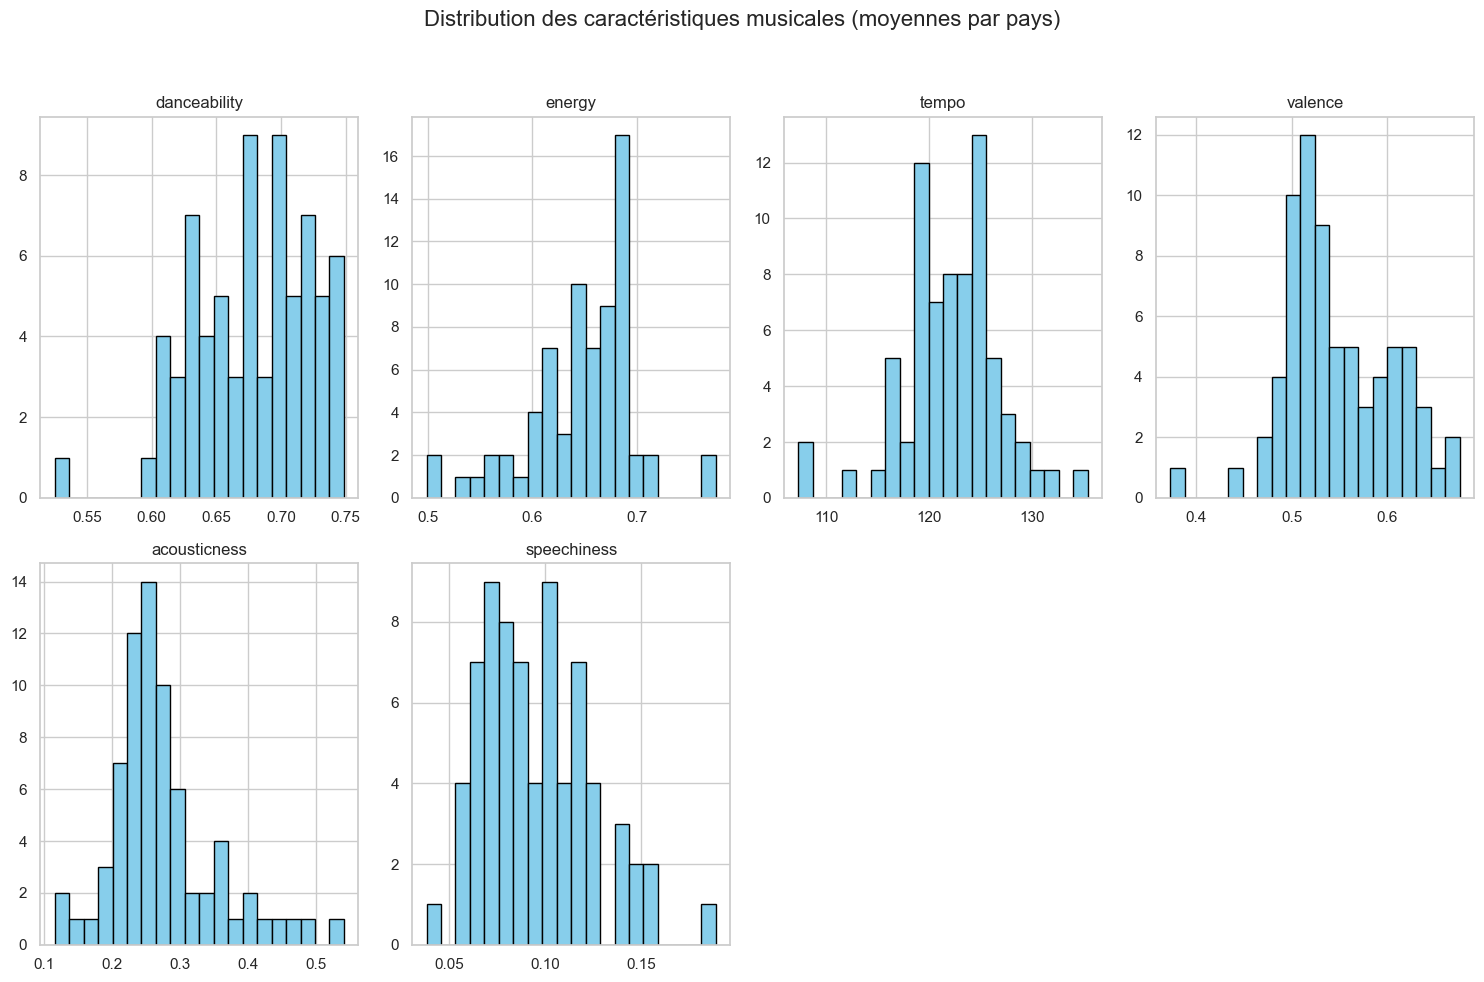

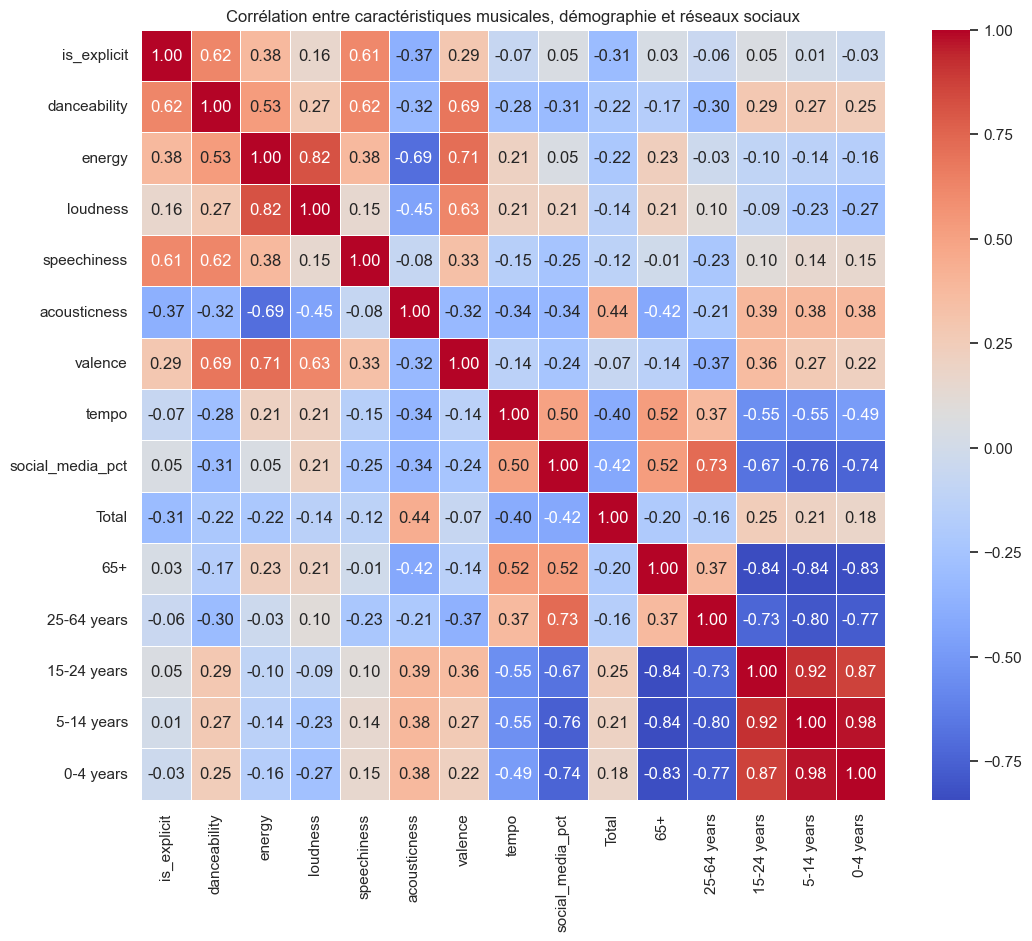

In [64]:
analyze_data(merged_df)

Variance expliquée : [0.38519082 0.26018473 0.09311919]
Variance cumulée : 0.7384947392621364


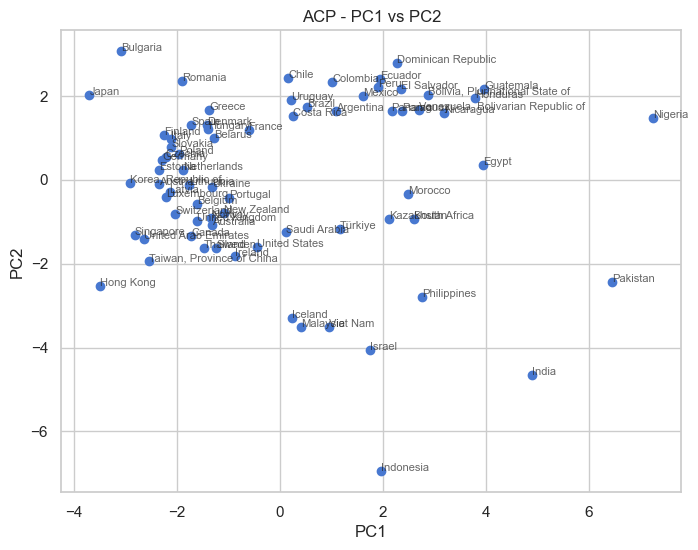

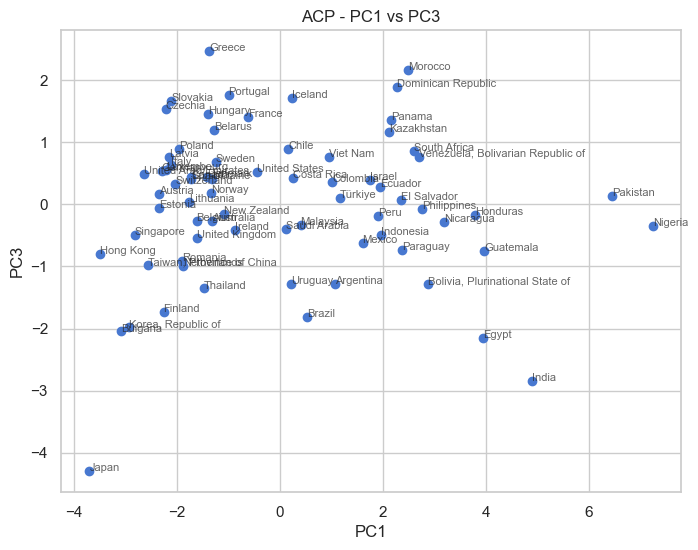

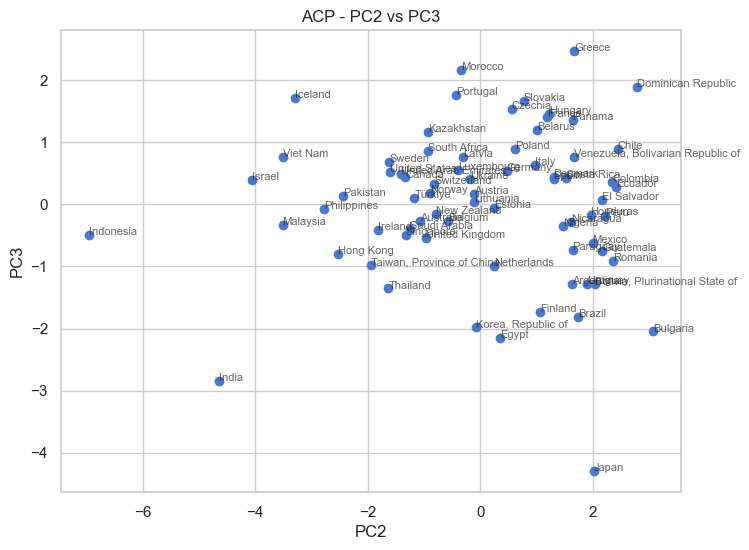

In [65]:
# Calcul de l'ACP

n_components = 3
pc_df, pca, feature_names, X_scaled= perform_pca(merged_df, n_components)

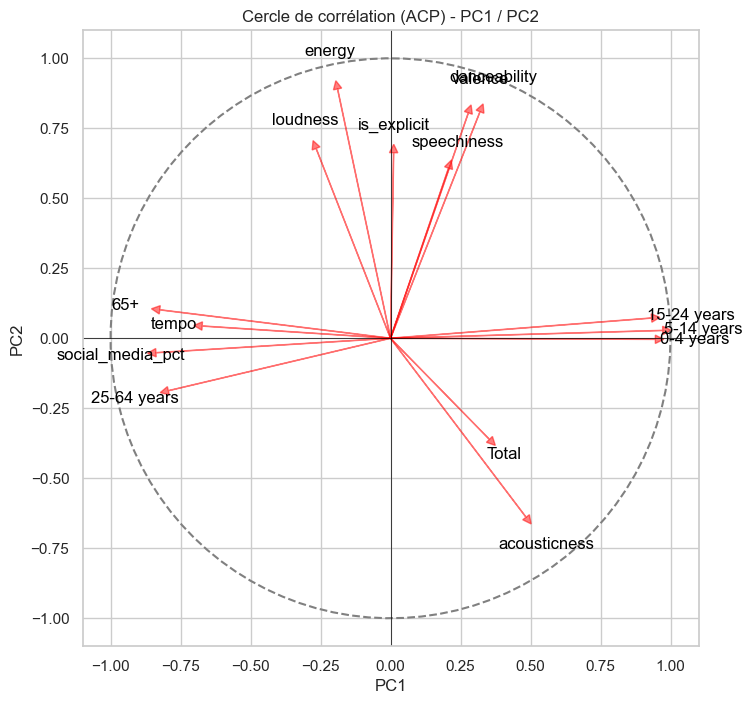

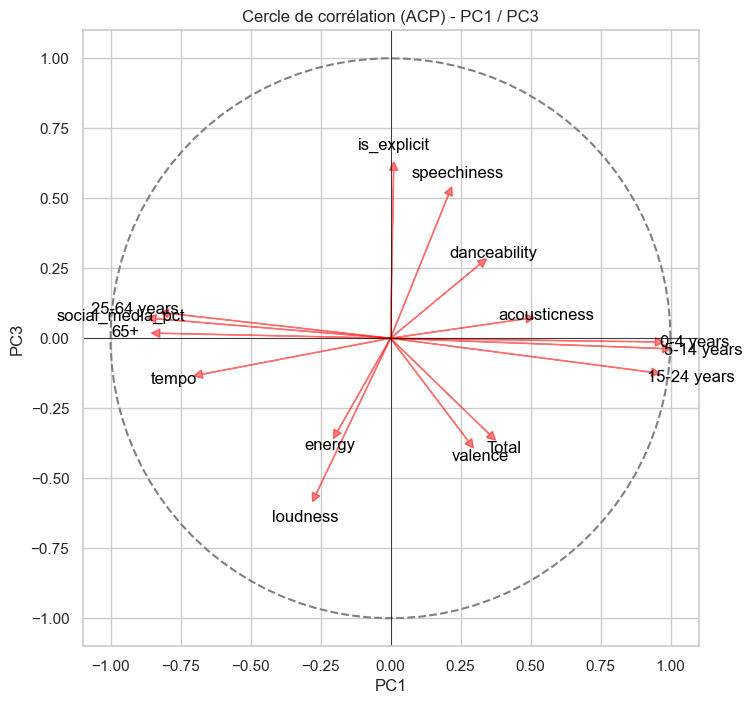

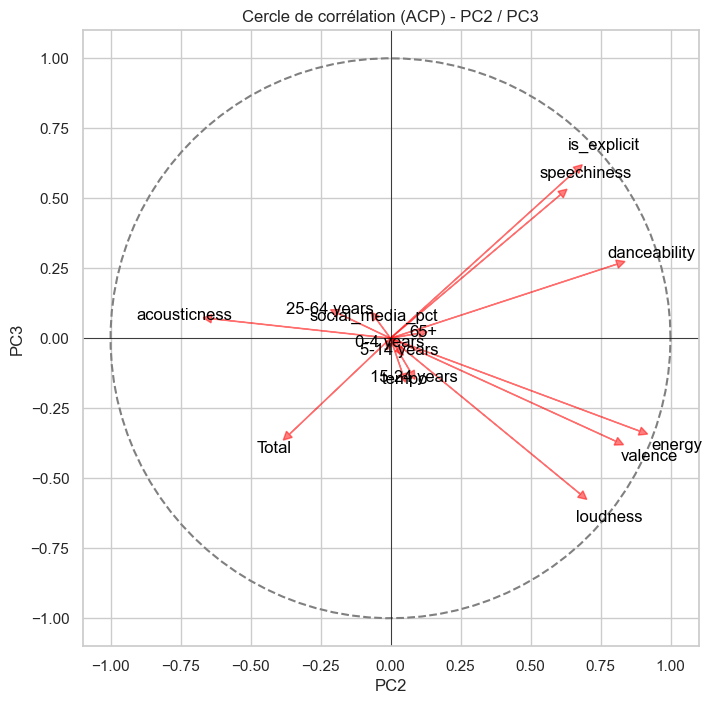

In [66]:
# Affichage des cercles de corrélation
plot_correlation_circle(pca, feature_names, n_components)

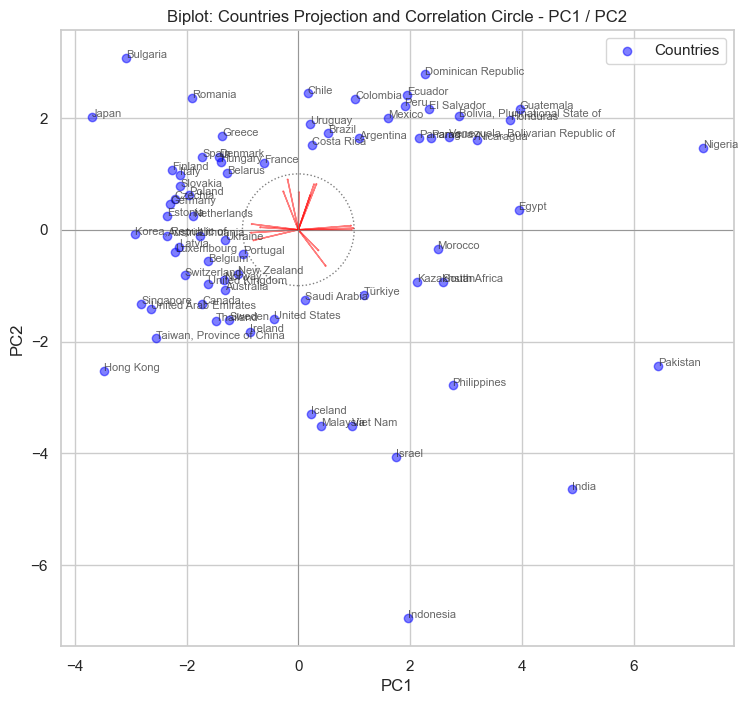

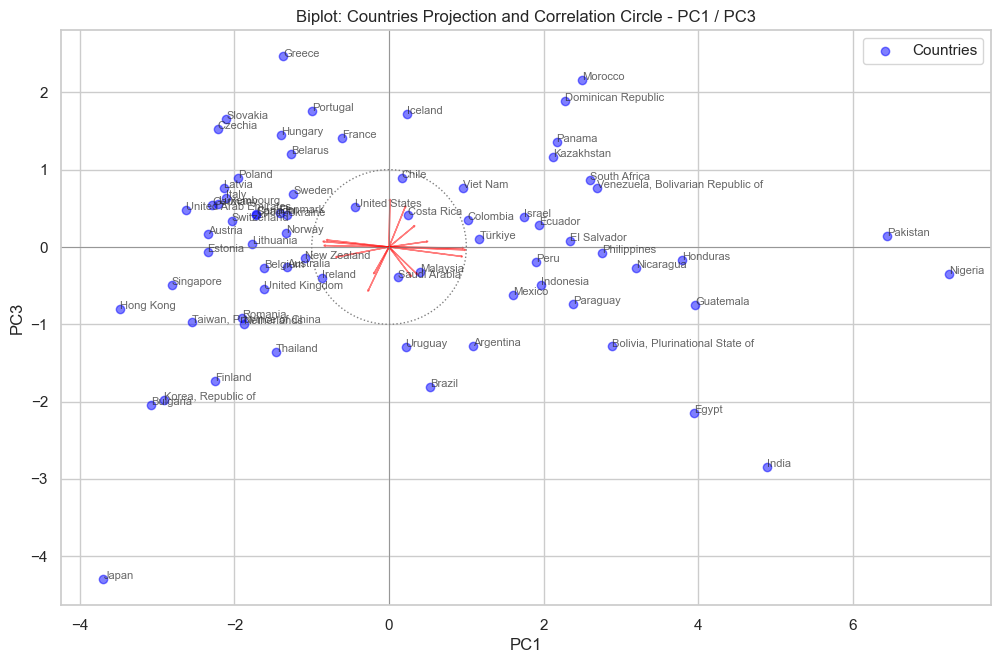

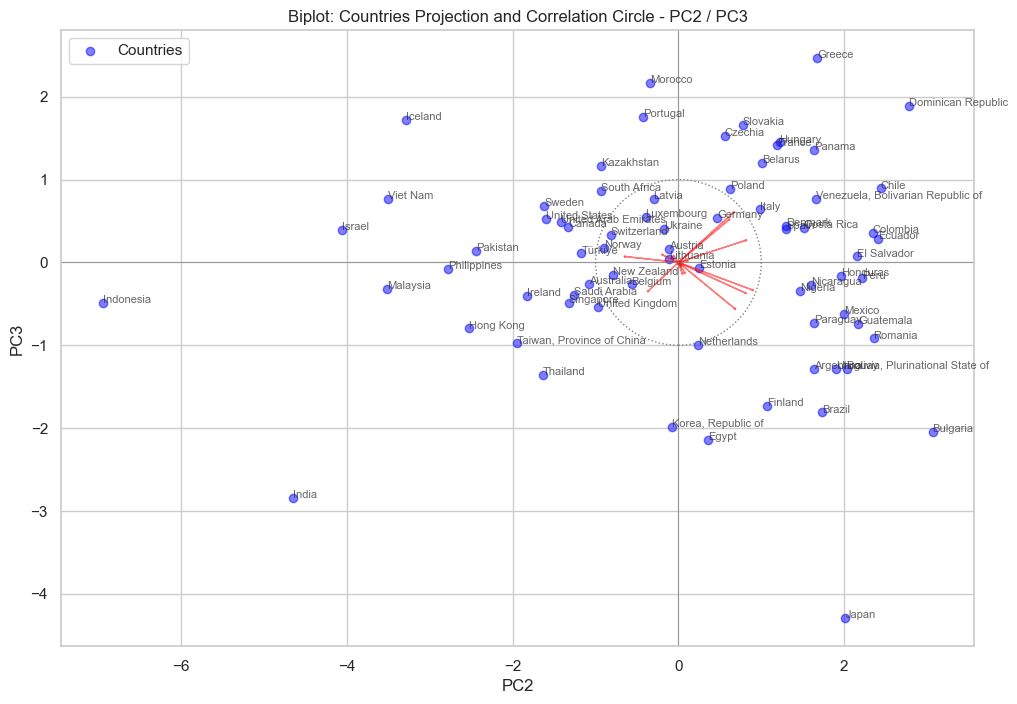

In [67]:
# Affichage des biplots avec les cercles de corrélation et les pays
plot_biplot(pc_df, pca, feature_names, merged_df['country'], n_components)

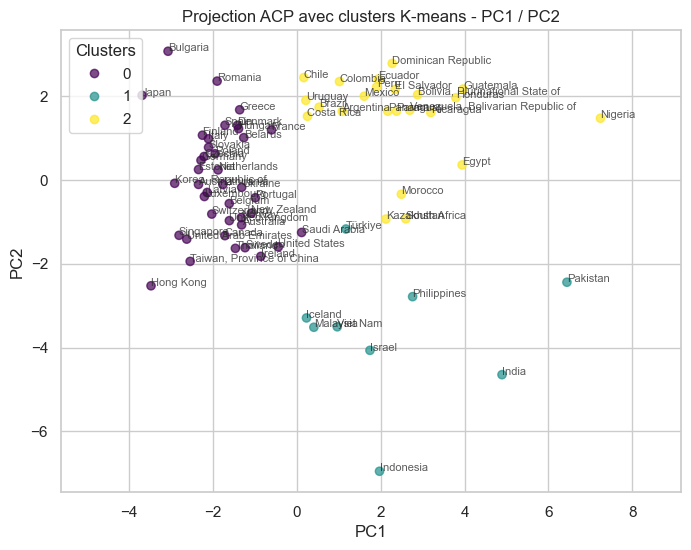

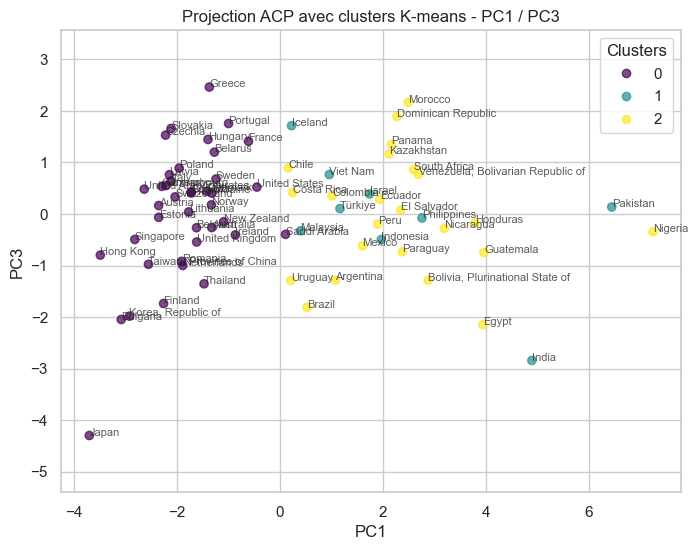

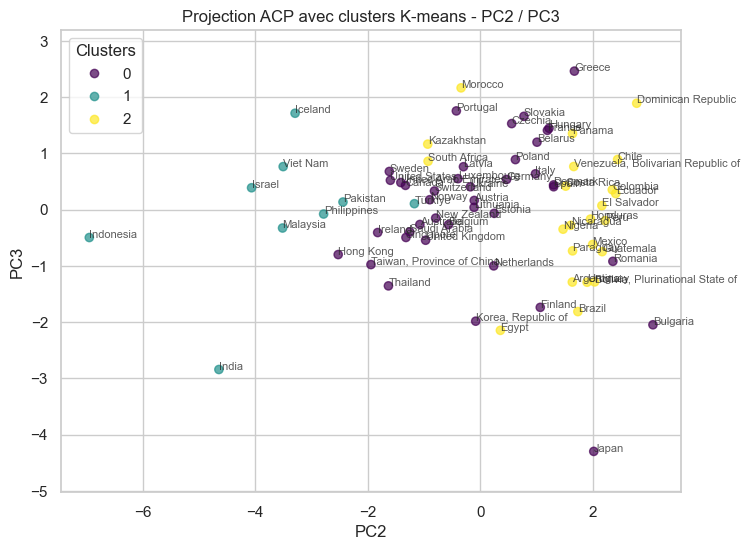

In [68]:
# Application de K-means (avec 3 clusters) et affichage des clusters
perform_kmeans(pc_df, n_components, n_clusters=3, annotation_labels=merged_df['country'])

In [69]:
# Étape 10 : Calcul des statistiques globales
def calcul_statistiques_globales(df, numeric_cols):
    result = {}
    for col in numeric_cols:
        values = df[col].dropna()

        mean_val = values.mean()
        std_val = values.std(ddof=1)  # écart-type échantillon
        n = len(values)

        if n > 1:
            se = std_val / np.sqrt(n)
            ci_low_95 = mean_val - 1.96 * se
            ci_up_95 = mean_val + 1.96 * se
            ci_low_99 = mean_val - 2.576 * se
            ci_up_99 = mean_val + 2.576 * se
        else:
            se = np.nan
            ci_low = np.nan
            ci_up = np.nan

        abs_errors = abs(values - mean_val)
        rel_errors = (abs_errors / mean_val) * 100 if mean_val != 0 else np.nan

        result[col] = {
            'Moyenne': mean_val,
            'Écart type': std_val,
            'Nombre de valeurs utilisées': n,
            'Erreur standard': se,
            'Intervalle de confiance 95%': (ci_low_95, ci_up_95),
            'Intervalle de confiance 99%': (ci_low_99, ci_up_99),
            'Erreur absolue moyenne': abs_errors.mean(),
            'Erreur relative moyenne (en %)': rel_errors.mean()
        }

    return pd.DataFrame(result).T.reset_index().rename(columns={'index': 'colonne'})

In [70]:
# Calcul des statistiques globales pour les colonnes d'intérêt
# et affichage des résultats
df_stats_globales = calcul_statistiques_globales(merged_df, ['social_media_pct', '25-64 years', 'danceability', 'energy', 'loudness', 'acousticness', 'valence', 'tempo'])
df_stats_globales

,colonne,Moyenne,Écart type,Nombre de valeurs utilisées,Erreur standard,Intervalle de confiance 95%,Intervalle de confiance 99%,Erreur absolue moyenne,Erreur relative moyenne (en %)
0,social_media_pct,0.697998,0.155515,72,0.018328,"(0.6620755473131421, 0.7339198553529642)","(0.650785727478313, 0.7452096751877934)",0.111588,15.986859
1,25-64 years,0.52121,0.055307,72,0.006518,"(0.5084344106766797, 0.5339849614312123)","(0.5044193241295388, 0.5380000479783532)",0.039089,7.49964
2,danceability,0.678062,0.045084,72,0.005313,"(0.6676485464889361, 0.6884764149051588)","(0.6643755957378155, 0.6917493656562794)",0.036998,5.456479
3,energy,0.648645,0.050934,72,0.006003,"(0.6368799988303392, 0.6604101924318592)","(0.6331823969786717, 0.6641077942835266)",0.038356,5.913262
4,loudness,-6.699555,0.771542,72,0.090927,"(-6.877772466446944, -6.521338346054677)","(-6.9337835425085865, -6.465327269993035)",0.559903,-8.357314
5,acousticness,0.274474,0.078406,72,0.00924,"(0.25636333239081877, 0.2925848584764926)","(0.25067137829164143, 0.29827681257566996)",0.056227,20.485506
6,valence,0.547947,0.05679,72,0.006693,"(0.534828946429809, 0.5610646719216903)","(0.5307061895667992, 0.5651874287847002)",0.04608,8.409514
7,tempo,122.162052,4.8075,72,0.566569,"(121.05157654232843, 123.27252801793563)","(120.70256988187587, 123.62153467838819)",3.601539,2.948165
